In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
sns.set_theme(style="whitegrid")

import copy

import numpy as np
import math
from scipy.stats import norm, \
    beta, cauchy, expon, rayleigh, uniform, multivariate_t, t, \
    rankdata, kendalltau, pearsonr
from scipy.stats.mstats import spearmanr
import scipy.integrate as integrate
import pandas as pd
import prophet
import yfinance as yf
from scipy.optimize import brentq, fsolve

import pyvinecopulib as pv

Importing plotly failed. Interactive plots will not work.


## The General Inference problem

Compute 
$$P(\textbf{Y<=y} | \textbf{X=x})$$

## Rosenblatt Transform

$$\mathbf{U} = (U_1, U_2, ... U_d)$$
$$\mathbf{V} = (V_1, V_2, ... V_d)$$
$$\mathbf{V} = R(\mathbf{U})$$

$$ V_j = C_{j|j-1,...1}(U_j|U_{j-1},...,U_1) $$

$$V_1 = C_{1}(U_1)$$
$$V_2 = C_{2|1}(U_2|U_1)$$
$$V_3 = C_{3|2,1}(U_3|U_2,U_1)$$
$$ \dots $$

## Vine Copula Example - Crypto Currencies

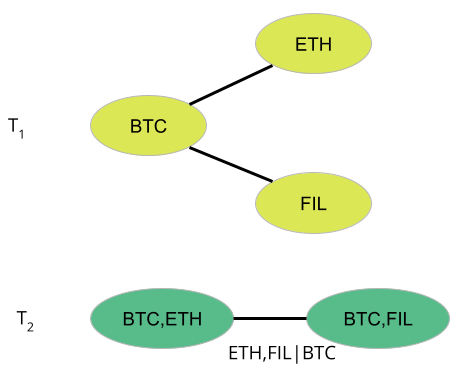

In [3]:
display.Image("crypto_vine_example.png")

In [4]:
tickers = ['BTC-USD', 'ETH-USD', 'FIL-USD']
data = yf.download(' '.join(tickers), start="2021-01-01", end="2023-12-31")

[*********************100%***********************]  3 of 3 completed


<IPython.core.display.Javascript object>


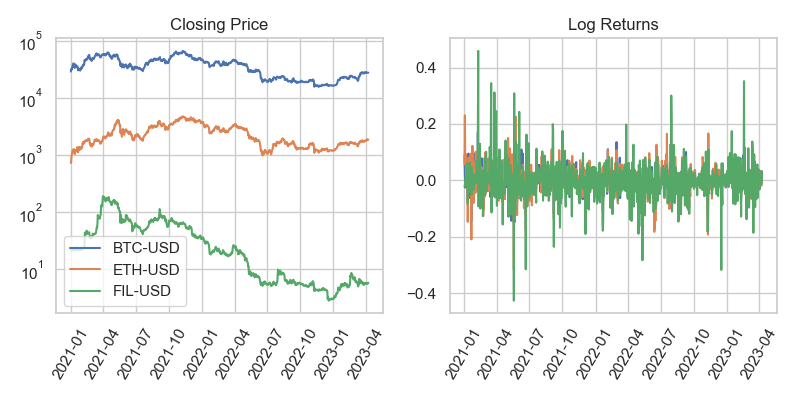

In [5]:
close_prices = data['Adj Close']
# compute log returns
returns_data = np.log1p(close_prices.pct_change())
returns_data = returns_data.reset_index().rename(columns={'Date': 'ds'})
returns_data['ds'] = pd.to_datetime(returns_data['ds']).dt.tz_localize(None)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
for tick in tickers:
    plt.plot(close_prices[tick], label=tick)
plt.xticks(rotation=60)
plt.title('Closing Price')
plt.yscale('log')
plt.legend()

plt.subplot(1,2,2)
for tick in tickers:
    plt.plot(returns_data['ds'], returns_data[tick], label=tick)
plt.xticks(rotation=60)
plt.title('Log Returns')

plt.tight_layout()

In [6]:
tick2data = {}
tick2model = {}
for tick in tickers:
    m = prophet.Prophet()
    df = returns_data[['ds', tick]].rename(columns={tick: 'y'})
    m.fit(df)
    
    # compute residuals
    df_forecast = m.predict()
    df = pd.merge(df, df_forecast, on='ds')
    df['residual'] = df['y'] - df['yhat']

    tick2data[tick] = df
    tick2model[tick] = m

07:14:46 - cmdstanpy - INFO - Chain [1] start processing
07:14:47 - cmdstanpy - INFO - Chain [1] done processing
07:14:47 - cmdstanpy - INFO - Chain [1] start processing
07:14:47 - cmdstanpy - INFO - Chain [1] done processing
07:14:47 - cmdstanpy - INFO - Chain [1] start processing
07:14:47 - cmdstanpy - INFO - Chain [1] done processing


<IPython.core.display.Javascript object>


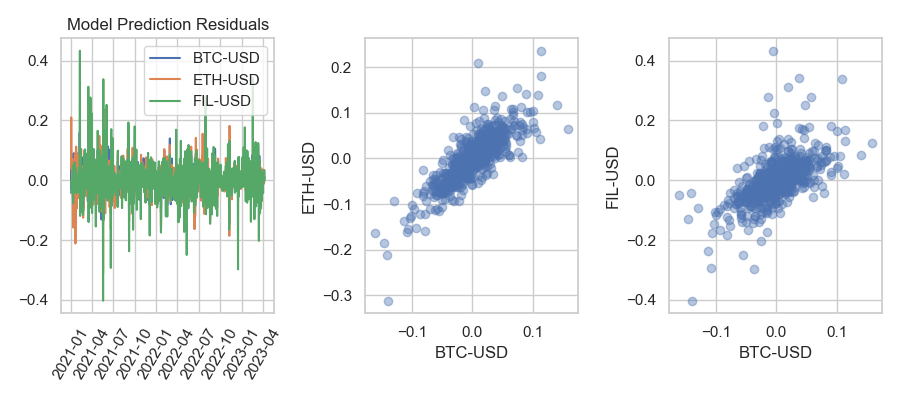

In [7]:
plt.figure(figsize=(9,4))

plt.subplot(1,3,1)
for tick in tickers:
    df = tick2data[tick]
    plt.plot(df['ds'], df['residual'], label=tick)
plt.xticks(rotation=60)
plt.legend()
plt.title('Model Prediction Residuals')

center_tick = 'BTC-USD'
remaining_tickers = copy.copy(tickers)
remaining_tickers.remove(center_tick)

plt.subplot(1,3,2)
t = 'ETH-USD'
plt.scatter(tick2data[center_tick]['residual'], tick2data[t]['residual'], alpha=0.4)
plt.xlabel(center_tick)
plt.ylabel(t)

plt.subplot(1,3,3)
t = 'FIL-USD'
plt.scatter(tick2data[center_tick]['residual'], tick2data[t]['residual'], alpha=0.4)
plt.xlabel(center_tick)
plt.ylabel(t)

plt.tight_layout()

In [8]:
X = pd.DataFrame()
X['btc_residual'] = tick2data['BTC-USD']['residual'] 
X['eth_residual'] = tick2data['ETH-USD']['residual'] 
X['fil_residual'] = tick2data['FIL-USD']['residual']
U = pv.to_pseudo_obs(X)

<IPython.core.display.Javascript object>


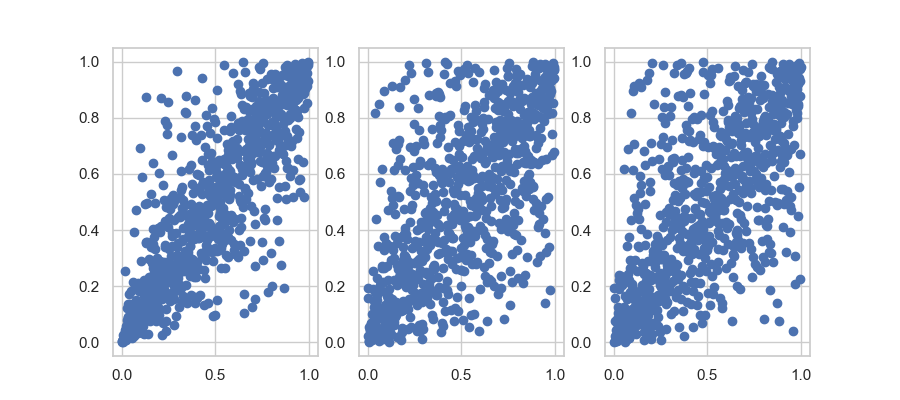

In [9]:
plt.figure(figsize=(9,4))

plt.subplot(1,3,1)
plt.scatter(U[:,0], U[:,1])

plt.subplot(1,3,2)
plt.scatter(U[:,0], U[:,2])

plt.subplot(1,3,3)
plt.scatter(U[:,1], U[:,2])

In [10]:
cop = pv.Vinecop(data=U, 
                 structure = pv.CVineStructure([3,2,1]))

In [11]:
cop

<pyvinecopulib.Vinecop>
** Tree: 0
3,1 <-> TLL, parameters = [30x30 grid]
2,1 <-> BB1 180°, parameters = 0.150281
 2.62745
** Tree: 1
3,2 | 1 <-> TLL, parameters = [30x30 grid]

In [12]:
cop.order

[3, 2, 1]

### Possible Conditional Distributions that we can compute
$$ P(U_3 \leq u_3 | U_2 = u_2, U_1 = u_1) $$
$$ P(U_2 \leq u_2 | U_1 = u_1) $$ 
$$ P(U_1 \leq u_1) $$

### Compute Inference for P(U<sub>2</sub> <= u<sub>2</sub> | U<sub>1</sub> = u<sub>1</sub>)

In [50]:
# NOTE: this will be inputted to the rosenblatt function to compute inference.
# the order matters very much here.  The input to the Rosenblatt function is NOT 
# according to the copula order, but is always in the form of: [u1, u2, u3, ...]
# See here for my discussion w/ the author of the library for further clarification:
#  https://github.com/vinecopulib/pyvinecopulib/issues/104

nn = 100
u_sim = np.vstack(
    [
        0.75 * np.ones(nn),
        np.linspace(0,1,nn),
        np.linspace(0,1,nn),
    ]
).T
print(u_sim.shape)

(100, 3)


In [51]:
v_sim = cop.rosenblatt(u_sim)

# NOTE: again, the order of the output matters very much in the 
# interpretation of the data. The order of the output vector v is NOT
# equal to the copula order, but rather [v1, v2, v3, ...]

<IPython.core.display.Javascript object>


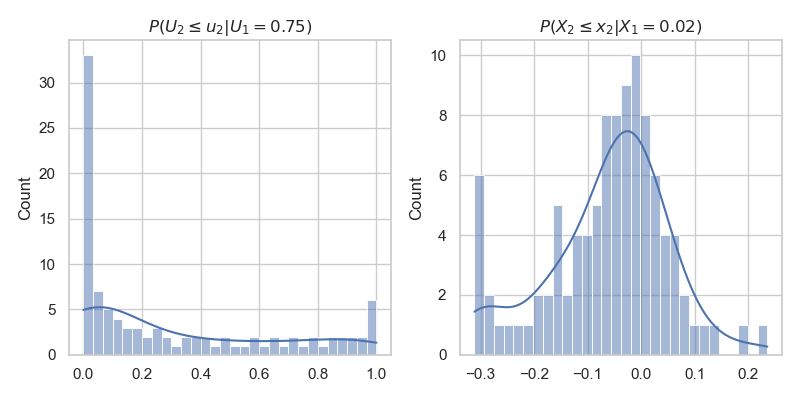

In [52]:
# NOTE: calling the quantile function is essentially doing an inverse
# cdf of X, at points given by v to convert the v data back into the X space.

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.histplot(v_sim[:,1], kde=True, bins=30)
plt.title(r'$P(U_2 \leq u_2 | U_1 = %0.02f)$' % (u_sim[0,0],))

plt.subplot(1,2,2)
x1 = np.quantile(X['btc_residual'].to_numpy(), u_sim[0,0])
sns.histplot(np.quantile(X['eth_residual'].to_numpy(), v_sim[:,1]), kde=True, bins=30)
plt.title(r'$P(X_2 \leq x_2 | X_1 = %0.02f)$' % (x1,))

plt.tight_layout()

### Compute Inference for P(U<sub>3</sub> <= u<sub>3</sub> | U<sub>2</sub> = u<sub>2</sub>, U<sub>1</sub>=u<sub>1</sub>)

In [53]:
# NOTE: this will be inputted to the rosenblatt function to compute inference.
# the order matters very much here.  The input to the Rosenblatt function is NOT 
# according to the copula order, but is always in the form of: [u1, u2, u3, ...]
# See here for my discussion w/ the author of the library for further clarification:
#  https://github.com/vinecopulib/pyvinecopulib/issues/104

nn = 100
u_sim = np.vstack(
    [
        0.75 * np.ones(nn),
        0.75 * np.ones(nn),
        np.linspace(0,1,nn),
    ]
).T
print(u_sim.shape)

(100, 3)


In [54]:
v_sim = cop.rosenblatt(u_sim)

# NOTE: again, the order of the output matters very much in the 
# interpretation of the data. The order of the output vector v is NOT
# equal to the copula order, but rather [v1, v2, v3, ...]

<IPython.core.display.Javascript object>


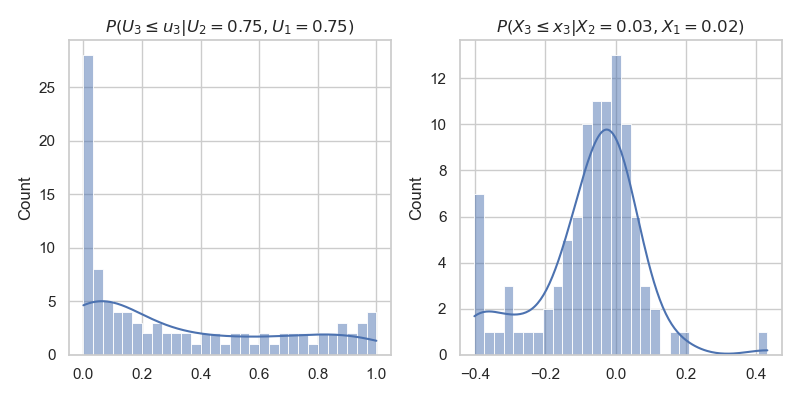

In [55]:
# NOTE: calling the quantile function is essentially doing an inverse
# cdf of X, at points given by v to convert the v data back into the X space.

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.histplot(v_sim[:,2], kde=True, bins=30)
plt.title(r'$P(U_3 \leq u_3 | U_2 = %0.02f, U_1 = %0.02f)$' % (u_sim[0,0], u_sim[1,0]))

plt.subplot(1,2,2)
x2 = np.quantile(X['eth_residual'].to_numpy(), u_sim[1,0])
x1 = np.quantile(X['btc_residual'].to_numpy(), u_sim[0,0])
sns.histplot(np.quantile(X['fil_residual'].to_numpy(), v_sim[:,2]), kde=True, bins=30)
plt.title(r'$P(X_3 \leq x_3 | X_2 = %0.02f, X_1 = %0.02f)$' % (x2, x1))

plt.tight_layout()